In [62]:
import pandas as pd 
from datastreams.datastream import Streamer
from pool import AMMPool, AMMPoolHistory, CPMM, AMMWithBaulking, OraclePool
import matplotlib as mpl
from matplotlib import pyplot as plt
import sysconfig

In [2]:
print(sysconfig.get_python_version())

3.10


**Get Uni trades stream**  

In [3]:
query_size = 10000

# instantiate Streamer object. 
# Note - unlike the cow queries, univ3 does not require multiple streamer instantations because the swaps field path is reset each iteration. 
# If the Cow queries were updated to use the same method, we could use the same streamer object for all queries.
univ3_ds = Streamer('https://api.thegraph.com/subgraphs/name/messari/uniswap-v3-ethereum')

# get a query field path from the query dictionary which is automatically populated in the Streamer object
uni_swaps_fp = univ3_ds.queryDict.get('swaps')

# define query path and parameters 
uni_swaps_qp = uni_swaps_fp(
        first=query_size, 
        orderBy='timestamp',
        orderDirection='asc',
        where = {'timestamp_gt':1643673600, 'pool': '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8', 'amountInUSD_gt': 100, 'amountOutUSD_gt': 100,} 
        )

# run query
uni_swaps_df = univ3_ds.runQuery(uni_swaps_qp)

FIELD - swaps


In [3]:
# save df to csv
# uni_swaps_df.to_csv('uni_swaps_df.csv')

uni_swaps_df = pd.read_csv('uni_swaps_df.csv')

In [4]:
# Find the first and last value in the timestamp column
first_timestamp_uni = uni_swaps_df['swaps_timestamp'].min()
last_timestamp_uni = uni_swaps_df['swaps_timestamp'].max()
print(f'first timestamp: {first_timestamp_uni} \nlast timestamp: {last_timestamp_uni}')

first timestamp: 1643673723 
last timestamp: 1645734304


**get chainlink pricing to value pools**

In [5]:
# load streamer class
chain_ds = Streamer('https://api.thegraph.com/subgraphs/name/openpredict/chainlink-prices-subgraph')
chain_price_feed = "ETH/USD"

In [6]:
# get a query field path from the query dictionary which is automatically populated in the Streamer object
chain_fp = chain_ds.queryDict.get('prices')

# add parameters to the settlements_qp.
chain_qp = chain_fp(
    first= 10000,
    orderBy='timestamp',
    orderDirection='asc',
    where = {'timestamp_gt':1643673600, 'assetPair': chain_price_feed}
    )

# run query
chain_df = chain_ds.runQuery(chain_qp)

FIELD - prices


In [7]:
# drop prices_id, endpoint. 
chain_df = chain_df.drop(['prices_id', 'endpoint'], axis=1)
# divide prices_price by 1e8 to get the price in USD
chain_df['prices_price'] = chain_df['prices_price'] / 10 ** 8

In [8]:
# Find the first and last value in the timestamp column
first_timestamp_chain = chain_df['prices_timestamp'].min()
last_timestamp_chain = chain_df['prices_timestamp'].max()
print(f'first timestamp: {first_timestamp_chain} \nlast timestamp: {last_timestamp_chain}')

first timestamp: 1643676926 
last timestamp: 1657307781


In [9]:
timestamps = pd.DataFrame({'prices_timestamp': range(first_timestamp_chain, last_timestamp_chain + 1)})

In [10]:
# left merge chain_df with empty timestamps_df
chain_df = pd.merge(timestamps, chain_df, on='prices_timestamp', how='left')

In [11]:
# Forward-fill missing values
chain_df.fillna(method='ffill', inplace=True)
# reset index
price_s = chain_df.set_index("prices_timestamp")["prices_price"]  # small chainlink prices?

**get initialization price**

In [12]:
# chainlink at first_timestamp of uni trades:
initialization_df = chain_df[chain_df["prices_timestamp"] == first_timestamp_chain]
initilizatioin_price = initialization_df.iloc[0,2]

# initialize 100m USDC supply reserve amount
USDC_reserves_USD = 100000000

In [13]:
token0_start = int(USDC_reserves_USD/initilizatioin_price)
print(f"Token 0 WETH initial reserves: \t{token0_start}")

token1_start = USDC_reserves_USD
print(f"Token 1 USDC initial reserves :\t{token1_start}")

Token 0 WETH initial reserves: 	37156
Token 1 USDC initial reserves :	100000000


**1.Simple AMM. SWAP ALL** 

In [14]:
# Create an instance of AMMPoolHistory 
feedlot1 = AMMPoolHistory(token0_start, token1_start)

In [15]:
# Instantiate the CPMM object with the AMMPool object
cpmm = CPMM(pool=feedlot1)
cpmm_SI_flow = AMMWithBaulking(cpmm, price_s)

In [16]:
# check that the price sources all start the same
print(f'price initialized by chainilnk: {initilizatioin_price}')
print(f'feedlot initialized price: {feedlot1.reserves[1] / feedlot1.reserves[0]}')
print(f'cpmm initialized price: {cpmm_SI_flow.amm.pool.reserves[1] / cpmm_SI_flow.amm.pool.reserves[0]}')

price initialized by chainilnk: 2691.31586673
feedlot initialized price: 2691.355366562601
cpmm initialized price: 2691.355366562601


In [17]:
uni_swaps_df['swaps_amountIn'] = uni_swaps_df['swaps_amountIn'].astype('float64')

In [18]:
uni_swaps_df['swaps_tokenIn_id'].unique()

array(['0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2',
       '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'], dtype=object)

In [19]:
# get minimum swaps_amountIn value
uni_swaps_df['swaps_amountIn'].min()

102385645.0

In [20]:
# Iterate through the rows of the dataframe
for index, row in uni_swaps_df.iterrows():
    if row['swaps_timestamp'] < 1643676926: continue # wait until we have chainlink prices

    # check if tokenIn is WETH or USDC. Apply decimal conversion accordingly.
    match row['swaps_tokenIn_id']:
        case '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2':  # check if tokenIn is WETh
            token = 0
            amt = row['swaps_amountIn'] / 10**18
        case '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48':  # check if tokenIn is USDC
            token = 1
            amt = row['swaps_amountIn'] / 10**6


    # Run the swap function on the AMM pool
    amt0, amt1 = cpmm_SI_flow.maybe_market_order_sell(amt,token,row['swaps_timestamp'])
    # print(f"Traded {amt0} for {amt1}\tat time {row['swaps_timestamp']}.")
    # print(f"Pool reserves: ({feedlot1.reserves[0], feedlot1.reserves[1]})")

Traded 0 for 0	at time 1643677266.
Pool reserves: ((37156, 100000000.0))
Traded -92 for 249755.238047	at time 1643677640.
Pool reserves: ((37064, 100249755.238047))
Traded -46 for 125000.0	at time 1643677829.
Pool reserves: ((37018, 100374755.238047))
Traded 4.981789650191381 for -13506	at time 1643677886.
Pool reserves: ((37022.98178965019, 100361249.238047))
Traded 7.3440111499850715 for -19904	at time 1643678003.
Pool reserves: ((37030.32580080018, 100341345.238047))
Traded 0 for 0	at time 1643678182.
Pool reserves: ((37030.32580080018, 100341345.238047))
Traded 0 for 0	at time 1643678222.
Pool reserves: ((37030.32580080018, 100341345.238047))
Traded 0 for 0	at time 1643678488.
Pool reserves: ((37030.32580080018, 100342494.469408))
Traded -67 for 184435.693324	at time 1643679112.
Pool reserves: ((36963.32580080018, 100526930.162732))
Traded 42.701966273337426 for -115999	at time 1643680005.
Pool reserves: ((37006.027767073516, 100410931.162732))
Traded 130.20733078781421 for -352061

In [21]:
results1_df = pd.DataFrame(feedlot1.history)

In [22]:
price_s = price_s * 1000

In [23]:
results1_df

,ts,reserve0,reserve1
0,0,37156.000000,1.000000e+08
1,1643677266,37148.000000,1.000234e+08
2,1643677266,37156.000000,1.000000e+08
3,1643677640,37064.000000,1.002498e+08
4,1643677829,37018.000000,1.003748e+08
...,...,...,...
13247,1645734294,38267.609191,1.003608e+08
13248,1645734304,38267.839191,1.003601e+08
13249,1645734304,38384.262199,1.000557e+08
13250,1645734304,38398.866030,1.000177e+08


In [24]:
# merge results1_df with chain_df on timestamp
results1_merged_df = pd.merge(results1_df, chain_df, left_on='ts', right_on='prices_timestamp', how='inner')

In [25]:
results1_merged_df['reserve0_usd'] = results1_merged_df['reserve0'] * results1_merged_df['prices_price']

In [26]:
results1_merged_df['tvl'] = results1_merged_df['reserve0_usd'] + results1_merged_df['reserve1']

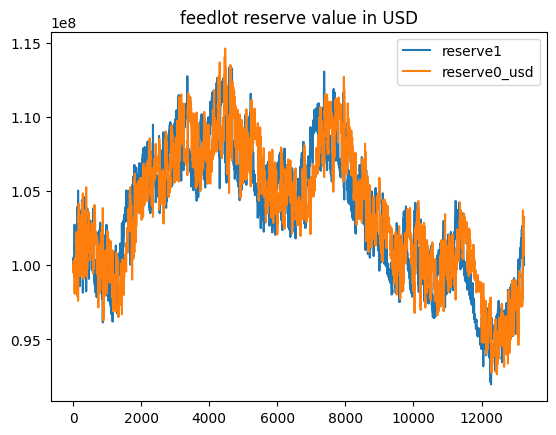

In [27]:
results1_merged_df[['reserve1', 'reserve0_usd']].plot()
plt.title('feedlot reserve value in USD')
plt.show();

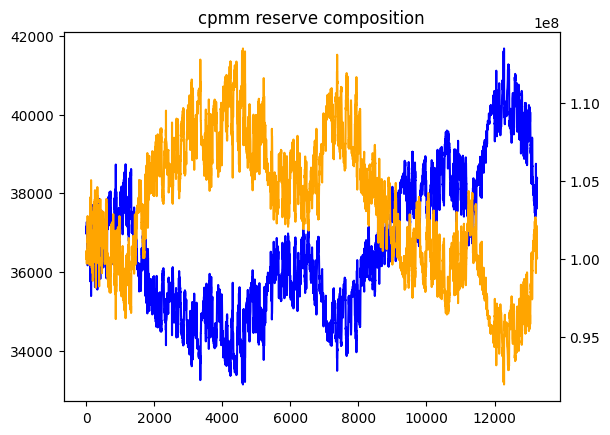

In [65]:
ax0 =results1_merged_df["reserve0"].plot(color='blue', label='USDC reserve')
ax1 = ax0.twinx()
ax1 =results1_merged_df["reserve1"].plot(color='orange', label='WETH reserve')
plt.title('cpmm reserve composition')
plt.show();

**OraclePool AMM**

**get cow trades for oracle pricing** 

In [36]:
cow_ds = Streamer('https://api.thegraph.com/subgraphs/name/cowprotocol/cow')

# get COW trades 

trades_fp = cow_ds.queryDict.get('trades')

# trades query path that gets token a -> token b trades
trades_qp = trades_fp(
    first=10000,
    orderBy='timestamp',
    orderDirection='asc',
    where={'timestamp_gt':1643673600, 'sellToken':'0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48',
           'buyToken':'0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'
    }
)

# run query
trades_df = cow_ds.runQuery(trades_qp)

FIELD - trades


In [38]:
# Set query size large enough to retrieve all tokens in the graph
query_size = 10000

token_fp = cow_ds.queryDict.get('tokens')

# add parameters to the settlements_qp.
token_qp = token_fp(
    first=query_size,
)

# run query
token_df = cow_ds.runQuery(token_qp)


FIELD - tokens


In [39]:
# Merge1 on sell token address.  x = sell token 
merged_df = pd.merge(trades_df, token_df, left_on='trades_sellToken_id', right_on='tokens_address')

(6910, 29)

In [40]:
# Merge2 on buy token address.  y = buy token 
cow_df = pd.merge(merged_df, token_df, left_on='trades_buyToken_id', right_on='tokens_address')

(6910, 42)

In [41]:
# save df to csv
# cow_df.to_csv('cow_df.csv')

cow_df = pd.read_csv('cow_df.csv')

In [42]:
# calculate buy and sell amounts from the correct decimal 
cow_df['sell_amount'] = cow_df.apply(lambda x: x['trades_sellAmount'] / (10**x['tokens_decimals_x']), axis=1)
cow_df['buy_amount'] = cow_df.apply(lambda x: x['trades_buyAmount'] / (10**x['tokens_decimals_y']), axis=1)

In [43]:
# calculate COW price defined sell amount / buy amount
cow_df['cow_price'] = cow_df['sell_amount'] / cow_df['buy_amount']

In [45]:
# Find the first and last value in the timestamp column
first_timestamp_cow = chain_df['prices_timestamp'].min()
last_timestamp_cow = chain_df['prices_timestamp'].max()

In [46]:
oracle_dict = [{"ts": row["trades_timestamp"], "p": row["cow_price"]} for _, row in cow_df.iterrows()]

**Oracle pool simulation**

In [70]:
# Create an instance of AMMPoolHistory 
feedlot2 = AMMPoolHistory(token0_start, token1_start)

In [71]:
feedlot3 = OraclePool(feedlot2, oracle_dict)

In [72]:
# Iterate through the rows of the dataframe
for index, row in uni_swaps_df.iterrows():
    if row['swaps_timestamp'] < 1643676926: continue # wait until we have chainlink prices

    # check if tokenIn is WETH or USDC. Apply decimal conversion accordingly.
    match row['swaps_tokenIn_id']:
        case '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2':  # check if tokenIn is WETh
            token = 0
            amt = row['swaps_amountIn'] / 10**18
        case '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48':  # check if tokenIn is USDC
            token = 1
            amt = row['swaps_amountIn'] / 10**6


    # Run the swap function on the AMM pool
    amt0, amt1 = feedlot3.market_order_sell(amt,token,row['swaps_timestamp'])
    # print(f"Traded {amt0} for {amt1}\tat time {row['swaps_timestamp']}.")
    # print(f"Pool reserves: ({feedlot1.reserves[0], feedlot1.reserves[1]})")

In [80]:
results2_df = pd.DataFrame(feedlot2.history)

In [83]:
# merge results1_df with chain_df on timestamp
results2_merged_df = pd.merge(results2_df, chain_df, left_on='ts', right_on='prices_timestamp', how='inner')

# calculate usd value of reserve0, which is the WETH reserves
results2_merged_df['reserve0_usd'] = results2_merged_df['reserve0'] * results2_merged_df['prices_price']

# calculate tvl
results2_merged_df['tvl'] = results2_merged_df['reserve0_usd'] + results2_merged_df['reserve1']

In [ ]:
results1_merged_df

In [ ]:
results2_merged_df

In [97]:
# count the number of swaps in results1 and results 2
print(f"Number of swaps in CPMM: {len(results1_merged_df)}")
print(f"Number of swaps in OraclePool: {len(results2_merged_df)}")

Number of swaps in CPMM: 13251
Number of swaps in OraclePool: 9991


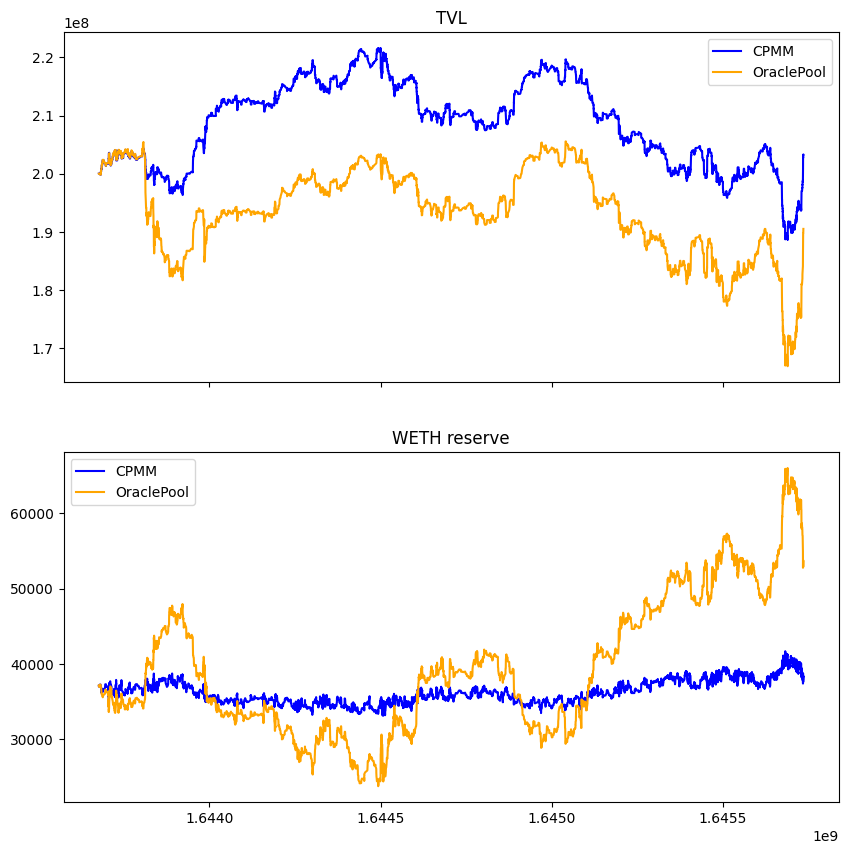

In [96]:
# plot subplots of merged dfs tvl
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
ax0.plot(results1_merged_df['prices_timestamp'], results1_merged_df['tvl'], color='blue', label='CPMM')
ax0.plot(results2_merged_df['prices_timestamp'], results2_merged_df['tvl'], color='orange', label='OraclePool')
ax0.set_title('TVL')
ax0.legend()
ax1.plot(results1_merged_df['prices_timestamp'], results1_merged_df['reserve0'], color='blue', label='CPMM')
ax1.plot(results2_merged_df['prices_timestamp'], results2_merged_df['reserve0'], color='orange', label='OraclePool')
ax1.set_title('WETH reserve')
ax1.legend()
plt.show();